In [1]:
import pandas as pd
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss

In [2]:
# Load pre-split data
train = pd.read_csv("../data/processed_data/train.csv")
val   = pd.read_csv("../data/processed_data/val.csv")
pred  = pd.read_csv("../data/processed_data/predict_oct2025.csv")

/var/folders/1r/ndm52t3d58j7bkp7_dx_ygc00000gn/T/ipykernel_6673/2489359151.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("../data/processed_data/train.csv")


In [3]:
# y_val er fasit, target_actual
y_val = val["target_actual"]

# Naiv prediksjon: bruk target_sched direkte
y_pred_baseline = val["target_sched"]

# For log loss og AUC trenger vi "sannsynligheter".
# Vi kan bruke target_sched som sannsynlighet (0 eller 1).
auc_baseline = roc_auc_score(y_val, y_pred_baseline)
eps = 1e-3  # lite justeringsledd
y_pred_proba = val["target_sched"].replace({0: eps, 1: 1-eps})

logloss_baseline = log_loss(y_val, y_pred_proba)

print("Baseline AUC:", auc_baseline)
print("Baseline Log Loss:", logloss_baseline)

Baseline AUC: 0.8731415683595523
Baseline Log Loss: 0.7452064573384425


In [4]:
y_train = train["target_actual"]
p_majority = y_train.mean()  # andel positive i trening
y_pred_proba = [p_majority] * len(y_val)

logloss_baseline = log_loss(y_val, y_pred_proba)
auc_baseline = roc_auc_score(y_val, y_pred_proba)
print("Baseline AUC:", auc_baseline)
print("Baseline Log Loss:", logloss_baseline)

Baseline AUC: 0.5
Baseline Log Loss: 0.6240677039165219


In [5]:
train.head(20)

,airport_group,hour,target_actual,target_sched,flights_cnt,avg_duration,max_duration,passenger_share,cargo_share,charter_share,...,dow,holiday,month,hournum,weekend,date,flights_cnt_prev,flights_cnt_next,daily_flights_cnt,weather
0,B,2018-01-01 07:00:00,0,0,0,0.00,0.0,0.0,0.0,0.0,...,0,True,1,7,0,2018-01-01,0,0,34,"{'@context': 'https://frost.met.no/schema', '@..."
1,F,2018-01-01 07:00:00,0,0,0,0.00,0.0,0.0,0.0,0.0,...,0,True,1,7,0,2018-01-01,0,0,23,NaN
2,A,2018-01-01 07:00:00,0,0,0,0.00,0.0,0.0,0.0,0.0,...,0,True,1,7,0,2018-01-01,0,0,25,NaN
3,C,2018-01-01 07:00:00,0,1,2,27.50,35.0,1.0,0.0,0.0,...,0,True,1,7,0,2018-01-01,0,4,28,NaN
4,G,2018-01-01 07:00:00,0,0,0,0.00,0.0,0.0,0.0,0.0,...,0,True,1,7,0,2018-01-01,0,0,29,NaN
5,E,2018-01-01 07:00:00,0,0,0,0.00,0.0,0.0,0.0,0.0,...,0,True,1,7,0,2018-01-01,0,0,37,NaN
6,D,2018-01-01 07:00:00,0,0,0,0.00,0.0,0.0,0.0,0.0,...,0,True,1,7,0,2018-01-01,0,0,34,NaN
7,B,2018-01-01 08:00:00,0,0,0,0.00,0.0,0.0,0.0,0.0,...,0,True,1,8,0,2018-01-01,0,0,34,NaN
8,F,2018-01-01 08:00:00,0,0,0,0.00,0.0,0.0,0.0,0.0,...,0,True,1,8,0,2018-01-01,0,0,23,NaN
9,C,2018-01-01 08:00:00,1,1,4,38.75,80.0,1.0,0.0,0.0,...,0,True,1,8,0,2018-01-01,2,2,28,NaN


In [6]:
# Define features
cat_cols = ["airport_group"]  
num_cols = [
    "flights_cnt", "avg_duration", "max_duration",
    "passenger_share", "cargo_share", "charter_share",
    "dow", "month", "hournum", "weekend",
    "target_sched", "holiday", "daily_flights_cnt",
    "flights_cnt_prev",	"flights_cnt_next"
]
feature_cols = cat_cols + num_cols

# Separate X / y
X_train = train[feature_cols]
y_train = train["target_actual"]

X_val = val[feature_cols]
y_val = val["target_actual"]

X_pred = pred[feature_cols]


# Preprocessing
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# Model
rf_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ))
])

# Train and evaluate
rf_model.fit(X_train, y_train)

print("Accuracy:", rf_model.score(X_val, y_val))
y_proba = rf_model.predict_proba(X_val)[:, 1]
print("AUC:", roc_auc_score(y_val, y_proba))
print("Log Loss:", log_loss(y_val, y_proba))


Accuracy: 0.8875123578843302
AUC: 0.9528236236553306
Log Loss: 0.25987037765552934


In [7]:
# Hent transformeren for kategoriske features
ohe = rf_model.named_steps["preprocess"].named_transformers_["cat"]

# Feature-navn for kategoriske
cat_feature_names = list(ohe.get_feature_names_out(["airport_group"]))

# Kombiner med numeriske
all_feature_names = cat_feature_names + num_cols
importances = rf_model.named_steps["clf"].feature_importances_

feat_importance = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_importance.head(15))

              feature  importance
7         flights_cnt    0.271298
17       target_sched    0.177430
10    passenger_share    0.125136
9        max_duration    0.106811
8        avg_duration    0.085987
21   flights_cnt_next    0.045547
19  daily_flights_cnt    0.044462
20   flights_cnt_prev    0.035018
15            hournum    0.033723
14              month    0.030544
13                dow    0.022303
1     airport_group_B    0.003483
16            weekend    0.002910
5     airport_group_F    0.002585
0     airport_group_A    0.002199


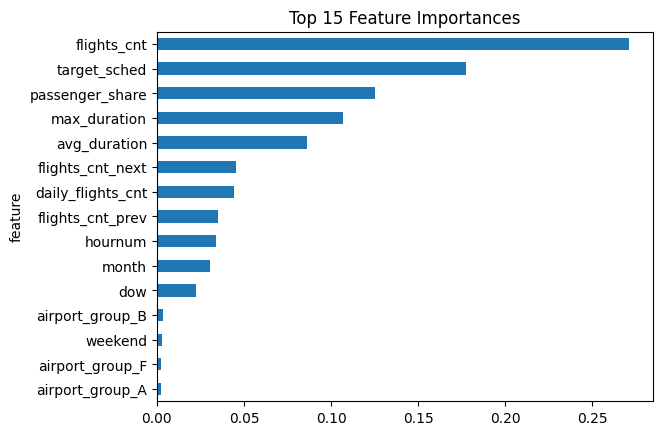

In [8]:
import matplotlib.pyplot as plt

feat_importance.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

# Predicting october 2025

In [9]:
y_proba_oct = rf_model.predict_proba(X_pred)[:, 1]


In [11]:
pred_out = pred.copy()
pred_out["proba_overlap"] = y_proba_oct  # sannsynlighet for overlap (target_actual=1)


pred_out["hour"] = pd.to_datetime(pred_out["hour"], errors="coerce")

pred_out = pred_out.sort_values("hour").reset_index(drop=True)

pred_out.to_csv("../data/prediction_data/predict_oct2025_with_proba.csv", index=False)

# Rask sanity check
print(pred_out.head())
print(pred_out["proba_overlap"].describe())

  airport_group                hour  target_sched  flights_cnt  avg_duration  \
0             A 2025-10-01 03:00:00           1.0            2         47.50   
1             C 2025-10-01 03:00:00           NaN            0          0.00   
2             F 2025-10-01 03:00:00           NaN            0          0.00   
3             E 2025-10-01 03:00:00           1.0            2         27.50   
4             G 2025-10-01 03:00:00           1.0            4         26.25   

   max_duration  passenger_share  cargo_share  charter_share airline  dow  \
0          65.0              1.0          0.0            0.0      WF    2   
1           0.0              0.0          0.0            0.0     NaN    2   
2           0.0              0.0          0.0            0.0     NaN    2   
3          30.0              1.0          0.0            0.0      WF    2   
4          35.0              1.0          0.0            0.0      WF    2   

   holiday  month  hournum  weekend        date  flights